In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from  matplotlib import pyplot as plt

# Useful functions

In [2]:
# TODO: think properly about inputs-outputs.
# In the spatial domain, the function below makes sense.

def rand_volume(shape, dimensions, radius, sigma = 0.1):
    """Generate a random smoothed spherical volume.

    Parameters
    ----------
    shape : 3 x 1 array
        Dimensions of the volume, in number of elements
    dimensions: 3 x 1 array
        Dimensions of the volume, in units (e.g. Angst?)
    radius: float
        Radius of spherical object
    sigma: float
        Sigma for the Gaussian window 

    Returns
    -------
    vol
        the volume
    """
    
    Nx, Ny, Nz = shape
    vol = np.random.randn(Nx, Ny, Nz) + 2
    #vol = np.ones(shape) + 5
    vol[vol < 0] = 0
    
    Lx, Ly, Lz = dimensions  
    dx, dy, dz = dimensions/shape # "pixel" size
    
    # By adjusting the interval by half a pixel on each side
    # we ensure the sampling locations are 
    # the centres of the "pixels"
    coords_x = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, Nx)
    coords_y = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, Ny)
    coords_z = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, Nz) 
    X, Y, Z = np.meshgrid(coords_x, coords_y, coords_z, indexing='xy')
    
    mask = create_mask(X, Y, Z, radius) 
    
    return low_pass_filter(mask*vol, X, Y, Z, sigma), X, Y, Z

In [3]:
def create_mask(X, Y, Z, radius):    
    mask = np.ones(X.shape)
    r = np.sqrt(X**2 + Y**2 + Z**2)
    mask[r > radius] = 0
    return mask

In [4]:
def low_pass_filter(vol, X, Y, Z, sigma):
    gauss = np.exp(-(X**2 + Y**2 + Z**2)/(2*sigma))
    gauss = gauss/max(gauss.ravel())
    gauss = np.fft.fftshift(gauss)
    
    low_pass_vol = np.fft.ifftn(np.fft.fftn(vol) * gauss)
    return np.real(low_pass_vol)

In [5]:
def volume_fourier(vol, dimensions, shape_f = None):
    """Calculate the FFT of the volume and return the frequency coordinates.
    
    Parameters
    ----------
    vol : 
        Volume in spatial domain
    dimensions: 3 x 1 array
        Spatial dimensions of the volume, in units (e.g. Angst?)
    shape_f: 3 x 1 array
        Shape of the Fourier volume

    Returns
    -------
    vol_f
        the Fourier volume
    X_f, Y_f, Z_f
        Fourier points
    """

    if shape_f == None:
        shape_f = vol.shape

    vol_f = np.fft.fftn(vol, shape_f)
    
    Nx, Ny, Nz = vol.shape
    Nx_f, Ny_f, Nz_f = shape_f
    dx, dy, dz = dimensions/vol.shape # "pixel" size
    
    x_freq = np.fft.fftfreq(Nx_f, dx)
    y_freq = np.fft.fftfreq(Ny_f, dy)
    z_freq = np.fft.fftfreq(Nz_f, dz)
    
    X_f, Y_f, Z_f = np.meshgrid(x_freq, y_freq, z_freq, indexing='xy')
    
    return vol_f, X_f, Y_f, Z_f, dx, dy, dz

In [78]:
def project(vol, X, Y, Z, angles):
    """Projection in the Fourier domain"""
    X_r, Y_r, Z_r = rotate(X, Y, Z, angles)
    
 
    slice_coords = np.array([X_r[:,:,0].flatten(), Y_r[:,:,0].flatten(),Z_r[:,:,0].flatten()])
    slice_interp = interpolate(slice_coords , X, Y, Z, vol)

    slice_interp_2d = slice_interp.reshape(X_r.shape[0], X_r.shape[1])

    slice_X = slice_coords[0,:].reshape(X_r.shape[0], X_r.shape[1])
    slice_Y = slice_coords[1,:].reshape(X_r.shape[0], X_r.shape[1])
    slice_Z = slice_coords[2,:].reshape(X_r.shape[0], X_r.shape[1])
    
    return slice_interp_2d, slice_X, slice_Y, slice_Z


In [7]:
# Rotation around the z axis to begin with
def rotate_z(X, Y, Z, alpha):
    rot_mat = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                       [np.sin(alpha), np.cos(alpha), 0],
                       [0, 0, 1]])
    
    coords = np.array([X.flatten(), Y.flatten(), Z.flatten()])
    coords_r = np.matmul(rot_mat, coords)
    
    X_r = coords_r[0,:].reshape(X.shape)
    Y_r = coords_r[1,:].reshape(Y.shape)
    Z_r = coords_r[2,:].reshape(Z.shape)
    
    return X_r, Y_r, Z_r

In [8]:
# Euler angles
# TODO: no need to apply the rotation to all coords if in Fourier
# we are only interested in the plane z=0 after rotation
def rotate(X, Y, Z, angles):
    """Rotate the coordinates given by X, Y, Z 
    with Euler angles alpha, betta, gamma
    around axes x, y, z respectively.
    
    Parameters
    ----------
    X, Y, Z : Nx x Ny x Nz arrays
        The coordinates as given by meshgrid
    angles:  3 x 1 array
        [alpha, beta, gamma] Euler angles
        
    Returns
    -------
    X_r, Y_r, Z_r : Nx x Ny x Nz arrays
        The coordinates after rotation.
    """
    
    alpha, beta, gamma = angles
    
    Rx = np.array([[1, 0, 0], 
                   [0, np.cos(alpha), -np.sin(alpha)],
                   [0, np.sin(alpha), np.cos(alpha)]])
    
    Ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                   [0, 1, 0],
                   [-np.sin(beta), 0, np.cos(beta)]])

    Rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                    [np.sin(gamma), np.cos(gamma), 0],
                    [0, 0, 1]])
    
    coords = np.array([X.flatten(), Y.flatten(), Z.flatten()])
    coords_r = Rz @ Ry @ Rx @ coords
    
    X_r = coords_r[0,:].reshape(X.shape)
    Y_r = coords_r[1,:].reshape(Y.shape)
    Z_r = coords_r[2,:].reshape(Z.shape)
    
    return X_r, Y_r, Z_r

In [9]:
# Nearest neighbour interpolation
def interpolate(i_coords, X, Y, Z, vol):
    """Given a volume vol sampled on meshgrid given
    by X, Y, Z, return the interpolated values of vol
    at the coordinates i_coords.
    
    Nearest neighbour interpolation.
    
    Parameters
    ----------
    i_coords: 3 x ... array
        Interpolation points
    X, Y, Z : Nx x Ny x Nz arrays
        Grid the volume is defined on
    vol : Nx x Ny x Nz array
        The volume
        
    Returns
    -------
    i_slice : NxNy x 1 array
        The interpolated values of vol.
    """
    
    x_freq = X[0,:,0]
    y_freq = Y[:,0,0]
    z_freq = Z[0,0,:]
    
    nearest_points_idxs = np.apply_along_axis(
        lambda c : find_nearest_grid_points_idx(c, x_freq, y_freq, z_freq), 
        axis = 0,
        arr = i_coords)
    
    # 'Interpolation'
    #i_vol = vol.take(nearest_points_idxs,axis = 0)
    i_slice = np.apply_along_axis(lambda idx : vol[tuple(idx)],
                               axis = 0,
                               arr = nearest_points_idxs)
    
    #print(i_coords)
    #print(nearest_points_idxs)
    #print(i_vol)
    
    return i_slice
    

In [10]:
# Can this be vectorized?
def find_nearest_grid_points_idx(coords, x_freq, y_freq, z_freq):
    """For a point given by coords and a grid defined by
    X, Y, Z, return the grid indices of the nearest grid point to coords.
    It assumes the grid is a Fourier DFT sampling grid in
    'standard' order (e.g. [0, 1, ..., n/2-1, -n/2, ..., -2, -1]).
    
    Parameters
    ---------
    coords: array of length 3
        The coordinates of the input points
    x_freq, y_freq, z_freq: Nx, Ny, Nz arrays
        The Fourier grids on which we want to find the nearest neighbour.
    """
    x, y, z = coords
    x0_idx, x1_idx = find_adjacent_grid_points_idx(x, x_freq)
    y0_idx, y1_idx = find_adjacent_grid_points_idx(y, y_freq)
    z0_idx, z1_idx = find_adjacent_grid_points_idx(z, z_freq)

    x0 = x_freq[x0_idx]
    x1 = x_freq[x1_idx]
    
    y0 = y_freq[y0_idx]
    y1 = y_freq[y1_idx]
    
    z0 = z_freq[z0_idx]
    z1 = z_freq[z1_idx]
    
    pts = np.array([[x0, y0, z0],
                    [x0, y0, z1],
                    [x0, y1, z0],
                    [x0, y1, z1],
                    [x1, y0, z0],
                    [x1, y0, z1],
                    [x1, y1, z0],
                    [x1, y1, z1]])
    pts_idx = np.array([[x0_idx, y0_idx, z0_idx],
                    [x0_idx, y0_idx, z1_idx],
                    [x0_idx, y1_idx, z0_idx],
                    [x0_idx, y1_idx, z1_idx],
                    [x1_idx, y0_idx, z0_idx],
                    [x1_idx, y0_idx, z1_idx],
                    [x1_idx, y1_idx, z0_idx],
                    [x1_idx, y1_idx, z1_idx]])  
    
    #print(pts)
    #print(pts_idx)
    #print(pts.shape)
    #print(coords.shape)
    
    
    sq_dist = np.sum((pts - coords.T)**2, axis=1)
    
    min_idx = np.argmin(sq_dist)
    
    return pts_idx[min_idx]

In [11]:
# Can this be vectorized for many coords/points?
def find_adjacent_grid_points_idx(p, grid):
    """For a one dimensional grid of Fourier samples
    and a point p, find the indices of the grid points
    on its left and its right.
    The Fourier samples must be in 'standard' order, 
    i.e. [0, 1, ..., n/2-1, -n/2, ..., -2, -1])
    """
    
    dx = grid[1]
    pt = np.floor(p / dx)
    n = len(grid)
    idx_left = int(np.mod(pt, n))
    idx_right = np.mod(idx_left + 1,n)
    return idx_left, idx_right

In [12]:
def test_find_nearest_grid_points_idx():    
    x_freq = np.fft.fftfreq(10,2)
    y_freq = np.fft.fftfreq(5,0.1)
    z_freq = np.fft.fftfreq(6,1)

    #print(x_freq)
    #print(y_freq)
    #print(z_freq)

    pts = [np.array([0, 0, 0]),
            np.array([0.04, 0, 0]),
            np.array([-0.24, -2, 0.168]),
            np.array([-0.01, 4, -0.48])]
    pts_grid_idxs = [np.array([0, 0, 0]),
            np.array([1, 0, 0]),
            np.array([5, 4, 1]),
            np.array([0, 2, 3])]

    for p, pt_grid_idx in zip(pts, pts_grid_idxs):
        #print(p, pt_grid_idx)
        idx_found = find_nearest_grid_points_idx(p, x_freq, y_freq, z_freq)
        #print(idx_found)
        assert(sum((idx_found-pt_grid_idx)**2) == 0)

    return
       
test_find_nearest_grid_points_idx()

In [13]:
def test_interpolate():
    x_freq = np.fft.fftfreq(10,2)
    y_freq = np.fft.fftfreq(5,0.1)
    z_freq = np.fft.fftfreq(6,1)
    
    X,Y,Z = np.meshgrid(x_freq, y_freq, z_freq, indexing = 'xy')
    
    vol = np.random.randn(len(x_freq), len(y_freq), len(z_freq))

    i_coords = np.array([[0, 0.04, -0.24, -0.01],
                         [0, 0, -2, 4],
                         [0, 0, 0.168, -0.48]])
        
    i_vol_correct = np.array([vol[0,0,0],
                vol[1,0,0],
                vol[5,4,1],
                vol[0,2,3]])

    i_vol = interpolate(i_coords, X, Y, Z, vol)

    assert(sum((i_vol - i_vol_correct)**2) == 0)

    return

test_interpolate()

# Putting everything together

In [32]:
# Create a volume

nx = 128
shape = nx * np.ones(3, dtype=np.int32)
dimensions = 10 * np.ones(3)
radius = 2
sigma = 10

v, X, Y, Z = rand_volume(shape, dimensions, radius, sigma)

In [79]:
# Take the Fourier transform, rotate 
# and interpolate the new z=0 slice

v_f, X_f, Y_f, Z_f, _, _, _ = volume_fourier(v, dimensions)

#angles = np.array([np.pi/3, np.pi/10, 3*np.pi/4])
angles = np.array([0,0,0])

slice_interp_2d, slice_X, slice_Y, slice_Z = project(v_f, X_f, Y_f, Z_f, angles)

#slice_interp
print(slice_Z.shape)



(128, 128)


Text(0.5, 1.0, 'Volume slice')

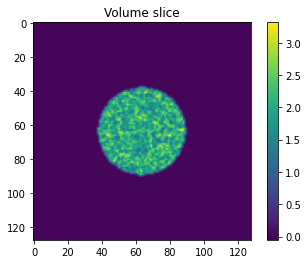

In [80]:
plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume slice')

Text(0.5, 1.0, 'Vol FFT slice')

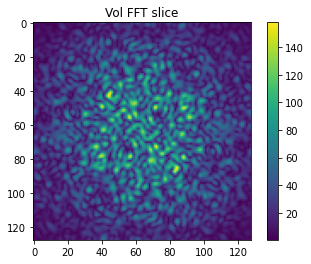

In [81]:
plt.imshow(np.fft.fftshift(abs(v_f[:,:,int(np.floor(v.shape[2]/2))])))
plt.colorbar()

plt.title('Vol FFT slice')

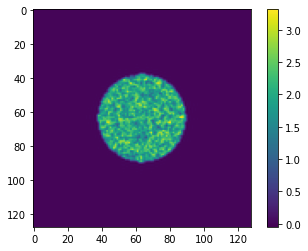

In [71]:
iv_f = np.fft.ifftn(v_f)
plt.imshow(np.real(iv_f[:,:,int(np.floor(v.shape[2]/2))]))
plt.colorbar()

Text(0.5, 1.0, 'X_f coords')

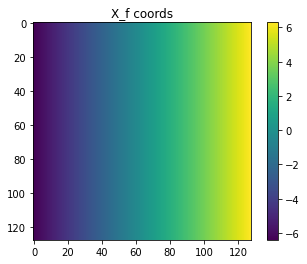

In [72]:
plt.imshow(np.fft.fftshift(X_f[:,:,0]))
plt.colorbar()
plt.title('X_f coords')

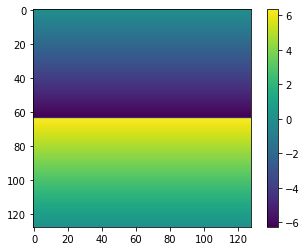

In [73]:
alpha = 4*np.pi/8.7
beta = 15*np.pi/3
gamma = 3*np.pi/4
angles = np.array([alpha, beta, gamma])
X_fr, Y_fr, Z_fr = rotate(X_f, Y_f, Z_f, angles)
#plt.imshow(np.fft.fftshift(Z_fr[:,:,0]))
plt.imshow(Z_fr[:,:,0])
plt.colorbar()

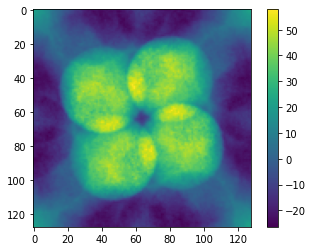

In [111]:
angles = np.array([0,0,np.pi/10])

slice_interp_2d, slice_X, slice_Y, slice_Z = project(v_f, X_f, Y_f, Z_f, angles)

plt.imshow(np.real(np.fft.ifftn(slice_interp_2d)))
plt.colorbar()

In [102]:
pj = np.fft.ifftn(slice_interp_2d)

In [106]:
sum(np.imag(pj).ravel())

-2.058502455339474e-15